# Interactive Data Merge Tool

**Run in browser Jupyter** (not VS Code): `jupyter notebook` in Terminal

**2 cells to run:**
1. **Cell 1** - Setup (run once)
2. **Cell 2** - Interactive menu (type commands inline, see results)

**Quick Start:** `load` a file, `preview` it, `clean` to select sweeps, `merge` to combine, `export` to save.

**See:** `INTERACTIVE_MERGE_GUIDE.md` for detailed workflows and examples.

In [ ]:
# ================================================================
# CELL 1: Setup - Run this once (Shift+Enter), then move to Cell 2
# ================================================================
# NOTE: Use browser Jupyter (not VS Code) for best experience
#       Launch with: jupyter notebook

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MaxNLocator
from pathlib import Path
from IPython.display import clear_output, display
import sys, copy
from datetime import datetime

SCRIPT_DIR = Path().resolve()
if str(SCRIPT_DIR) not in sys.path:
    sys.path.insert(0, str(SCRIPT_DIR))
from aat_data_loader_multisweep import AATDataLoader

%matplotlib inline

plt.rcParams.update({
    'figure.facecolor': 'white', 'axes.facecolor': 'white',
    'axes.linewidth': 1.5, 'axes.labelweight': 'bold', 'axes.labelsize': 14,
    'xtick.labelsize': 12, 'ytick.labelsize': 12, 'font.weight': 'bold',
    'legend.frameon': True, 'legend.framealpha': 0.9, 'legend.fontsize': 11,
})

PALETTES = {
    'muted': ['#CC6677','#332288','#DDCC77','#117733','#88CCEE','#882255','#44AA99','#999933','#AA4499'],
    'okabe': ['#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000'],
    'vibrant': ['#EE7733','#0077BB','#33BBEE','#EE3377','#CC3311','#009988','#BBBBBB'],
}


class DataMerger:
    """Interactive data merging tool for AAT/FET measurement data."""

    def __init__(self):
        self.loader = AATDataLoader()
        self.raw = {}           # label -> [measurements]
        self.cleaned = {}       # label -> [measurements]
        self.file_paths = {}    # label -> Path (source file/directory)
        self.merged = []        # final merged list
        self.merge_sources = [] # which label each merged sweep came from
        self.palette = 'muted'
        self.scale = 'nA'
        self.title = 'Merged Plot'
        self.legends = None
        self.annotations = []
        self.show_retrace = True
        self.xlim = None
        self.ylim = None
        self._file_counter = 0

    # ── Helpers ──────────────────────────────────────────────────

    def _ask(self, prompt, default=None):
        val = input(prompt).strip()
        return val if val else default

    def _ask_int(self, prompt, default=None):
        val = self._ask(prompt, str(default) if default is not None else None)
        try:
            return int(val) if val else default
        except ValueError:
            return default

    def _ask_float(self, prompt, default=None):
        val = self._ask(prompt, str(default) if default is not None else None)
        try:
            return float(val) if val else default
        except ValueError:
            return default

    def _ask_yn(self, prompt, default=True):
        hint = 'Y/n' if default else 'y/N'
        val = self._ask(f'{prompt} [{hint}]: ')
        if not val:
            return default
        return val.lower().startswith('y')

    def _colors(self):
        return PALETTES.get(self.palette, PALETTES['muted'])

    def _scale_factor(self):
        return 1e9 if self.scale == 'nA' else 1e6

    def _unit(self):
        return 'nA' if self.scale == 'nA' else r'$\mu$A'

    def _unit_plain(self):
        return 'nA' if self.scale == 'nA' else 'uA'

    def _default_outdir(self, label=None):
        """Get default output directory: input file's parent, or '.' fallback."""
        if label and label in self.file_paths:
            return str(self.file_paths[label].parent)
        # If no specific label, use the first loaded file's directory
        if self.file_paths:
            return str(next(iter(self.file_paths.values())).parent)
        return '.'

    def _ask_outdir(self, label=None):
        """Ask for output directory with smart default."""
        default = self._default_outdir(label)
        return self._ask(f'Output directory [{default}]: ', default)

    def _get_data(self, label):
        """Get cleaned data if available, otherwise raw."""
        return self.cleaned.get(label, self.raw.get(label, []))

    def _print_sweep_table(self, measurements, label=''):
        prefix = f'{label} | ' if label else ''
        for i, m in enumerate(measurements):
            vg = m['forward']['Vg']
            bwd = 'Yes' if m['backward'] else 'No'
            print(f'  {prefix}Sweep {i}: Vd={m["Vd"]:.2f}V | '
                  f'Vg=[{vg[0]:.1f} to {vg[-1]:.1f}]V | '
                  f'Retrace={bwd} | Points={len(vg)}')

    def _pick_label(self, prompt='Select file'):
        labels = list(self.raw.keys())
        if not labels:
            print('No files loaded yet!')
            return None
        print(f'\nLoaded files:')
        for i, l in enumerate(labels):
            status = ' [cleaned]' if l in self.cleaned else ''
            print(f'  {i+1}. {l}{status}')
        choice = self._ask(f'{prompt} (number or name): ')
        if not choice:
            return None
        try:
            idx = int(choice) - 1
            if 0 <= idx < len(labels):
                return labels[idx]
        except ValueError:
            if choice in labels:
                return choice
        print(f'Invalid selection: {choice}')
        return None

    def _get_ig(self, sweep_data, n_points):
        """Get Ig array from sweep data, fallback to zeros if missing."""
        if 'Ig' in sweep_data and len(sweep_data['Ig']) == n_points:
            return sweep_data['Ig']
        return np.zeros(n_points)

    def _save_sweeps_to_file(self, sweeps, filepath):
        """Save a list of sweep dicts to a Keysight-compatible .txt file."""
        with open(filepath, 'w') as f:
            f.write('V2\tI1\tI2\tV1\n')
            f.write('V\tA\tA\tV\n')
            for m in sweeps:
                vd = m['Vd']
                fwd = m['forward']
                n_fwd = len(fwd['Vg'])
                ig_fwd = self._get_ig(fwd, n_fwd)
                for j in range(n_fwd):
                    f.write(f'{fwd["Vg"][j]:.6E}\t{fwd["Id"][j]:.6E}\t{ig_fwd[j]:.6E}\t{vd:.6E}\n')
                if m['backward']:
                    bwd = m['backward']
                    n_bwd = len(bwd['Vg'])
                    ig_bwd = self._get_ig(bwd, n_bwd)
                    for j in range(n_bwd):
                        f.write(f'{bwd["Vg"][j]:.6E}\t{bwd["Id"][j]:.6E}\t{ig_bwd[j]:.6E}\t{vd:.6E}\n')
        n_total = sum(len(m['forward']['Vg']) + (len(m['backward']['Vg']) if m['backward'] else 0)
                      for m in sweeps)
        return n_total

    def _format_axes(self, ax, title='', xlabel='$V_g$ (V)', ylabel=None):
        """Apply standard formatting to an axis."""
        if ylabel is None:
            ylabel = f'$I_d$ ({self._unit()})'
        ax.set_xlabel(xlabel, fontsize=14, fontweight='bold')
        ax.set_ylabel(ylabel, fontsize=14, fontweight='bold')
        if title:
            ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=8))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=8))
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.grid(False)
        for lbl in ax.get_xticklabels() + ax.get_yticklabels():
            lbl.set_fontweight('bold')

    # ── Core Actions ─────────────────────────────────────────────

    def load(self):
        """Load a data file."""
        path = self._ask('\nFile path (drag & drop or paste): ')
        if not path:
            return
        path = path.strip().strip("'\"")
        p = Path(path)
        if not p.exists():
            print(f'File not found: {path}')
            return

        self._file_counter += 1
        default_label = f'File_{self._file_counter}'
        label = self._ask(f'Label for this file [{default_label}]: ', default_label)

        if p.is_dir():
            measurements = self.loader.load_directory(p)
        else:
            measurements = self.loader.load_measurement(p)

        if measurements:
            self.raw[label] = measurements
            self.file_paths[label] = p.resolve()
            print(f'\n--- Loaded "{label}": {len(measurements)} sweep(s) from {p.name} ---')
            self._print_sweep_table(measurements)
        else:
            print('Failed to load data.')
            self._file_counter -= 1

    def status(self):
        """Show all loaded files and their status."""
        if not self.raw:
            print('\nNo files loaded yet. Use "load" to add files.')
            return
        print(f'\n{"="*65}')
        print(f'  {"Label":<15} {"Raw":<8} {"Cleaned":<10} {"Retrace":<10} {"Status"}')
        print(f'  {"-"*60}')
        for label, data in self.raw.items():
            n_raw = len(data)
            if label in self.cleaned:
                n_clean = len(self.cleaned[label])
                status = 'Cleaned'
            else:
                n_clean = '-'
                status = 'Raw'
            has_bwd = any(m['backward'] for m in self._get_data(label))
            retrace = 'Yes' if has_bwd else 'No'
            print(f'  {label:<15} {n_raw:<8} {str(n_clean):<10} {retrace:<10} {status}')
        print(f'{"="*65}')
        if self.merged:
            print(f'  Merged data: {len(self.merged)} sweep(s) ready')

    def preview(self):
        """Preview a file's sweeps."""
        label = self._pick_label('Preview which file')
        if not label:
            return

        data = self._get_data(label)
        is_cleaned = label in self.cleaned
        colors = self._colors()
        sf = self._scale_factor()

        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        for i, m in enumerate(data):
            c = colors[i % len(colors)]
            ax.plot(m['forward']['Vg'], m['forward']['Id']*sf, '-', color=c,
                    linewidth=2.5, label=f'Sweep {i}: Vd={m["Vd"]:.1f}V (fwd)')
            if m['backward']:
                ax.plot(m['backward']['Vg'], m['backward']['Id']*sf, '--', color=c,
                        linewidth=1.5, alpha=0.4, label=f'Sweep {i}: Vd={m["Vd"]:.1f}V (bwd)')
        tag = 'CLEANED' if is_cleaned else 'RAW'
        self._format_axes(ax, title=f'{label} [{tag}] - {len(data)} sweep(s)')
        ax.legend(fontsize=9, loc='best')
        plt.tight_layout()
        plt.show()
        self._print_sweep_table(data, label)

    def clean(self):
        """Interactively clean a file (select sweeps, remove retrace, trim Vg)."""
        label = self._pick_label('Clean which file')
        if not label:
            return

        source = self.raw[label]
        print(f'\n--- Cleaning "{label}" ({len(source)} sweeps) ---')
        self._print_sweep_table(source)

        # 1. Select sweeps
        print(f'\n[1/3 Sweep Selection]')
        sel = self._ask(f'Keep which sweeps? (e.g. 0,2,4 or "all") [all]: ', 'all')
        if sel.lower() == 'all':
            keep_idx = list(range(len(source)))
        else:
            try:
                keep_idx = [int(x.strip()) for x in sel.split(',')]
            except ValueError:
                print('Invalid input, keeping all.')
                keep_idx = list(range(len(source)))

        # 2. Remove retrace?
        print(f'\n[2/3 Retrace]')
        remove_retrace = not self._ask_yn('Keep retrace (backward sweep)?', default=True)

        # 3. Trim voltage range?
        print(f'\n[3/3 Voltage Trim]')
        do_trim = self._ask_yn('Trim Vg range?', default=False)
        vg_min, vg_max = None, None
        if do_trim:
            vg_min = self._ask_float('  Vg min (e.g. -6): ')
            vg_max = self._ask_float('  Vg max (e.g. 0): ')

        # Apply
        cleaned = []
        for i in keep_idx:
            if i < 0 or i >= len(source):
                print(f'  Sweep {i}: SKIPPED (out of range)')
                continue
            m = copy.deepcopy(source[i])

            if remove_retrace:
                m['backward'] = None

            if vg_min is not None or vg_max is not None:
                lo = vg_min if vg_min is not None else -np.inf
                hi = vg_max if vg_max is not None else np.inf
                mask = (m['forward']['Vg'] >= lo) & (m['forward']['Vg'] <= hi)
                m['forward']['Vg'] = m['forward']['Vg'][mask]
                m['forward']['Id'] = m['forward']['Id'][mask]
                if 'Ig' in m['forward']:
                    m['forward']['Ig'] = m['forward']['Ig'][mask]
                if m['backward']:
                    mask_b = (m['backward']['Vg'] >= lo) & (m['backward']['Vg'] <= hi)
                    m['backward']['Vg'] = m['backward']['Vg'][mask_b]
                    m['backward']['Id'] = m['backward']['Id'][mask_b]
                    if 'Ig' in m['backward']:
                        m['backward']['Ig'] = m['backward']['Ig'][mask_b]

            cleaned.append(m)

        self.cleaned[label] = cleaned
        print(f'\nResult: {len(cleaned)} sweep(s) kept')
        self._print_sweep_table(cleaned, label)

        if self._ask_yn('\nShow before/after comparison?', default=True):
            self._compare_plot(label)

    def _compare_plot(self, label):
        """Show before/after comparison."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        colors = self._colors()
        sf = self._scale_factor()

        for i, m in enumerate(self.raw[label]):
            c = colors[i % len(colors)]
            ax1.plot(m['forward']['Vg'], m['forward']['Id']*sf, '-', color=c,
                    linewidth=2, label=f'S{i}: Vd={m["Vd"]:.1f}V')
            if m['backward']:
                ax1.plot(m['backward']['Vg'], m['backward']['Id']*sf, '--', color=c, linewidth=1.5, alpha=0.4)
        self._format_axes(ax1, title=f'{label} - BEFORE ({len(self.raw[label])} sweeps)')
        ax1.title.set_color('red')
        ax1.legend(fontsize=8)

        for i, m in enumerate(self.cleaned[label]):
            c = colors[i % len(colors)]
            ax2.plot(m['forward']['Vg'], m['forward']['Id']*sf, '-', color=c,
                    linewidth=2, label=f'Vd={m["Vd"]:.1f}V')
            if m['backward']:
                ax2.plot(m['backward']['Vg'], m['backward']['Id']*sf, '--', color=c, linewidth=1.5, alpha=0.4)
        self._format_axes(ax2, title=f'{label} - AFTER ({len(self.cleaned[label])} sweeps)')
        ax2.title.set_color('green')
        ax2.legend(fontsize=8)

        plt.tight_layout()
        plt.show()

    def extract(self):
        """Extract specific sweeps from a file and save as plot + data file."""
        label = self._pick_label('Extract from which file')
        if not label:
            return

        data = self._get_data(label)
        print(f'\n--- Extract sweeps from "{label}" ---')
        self._print_sweep_table(data, label)

        sel = self._ask(f'\nWhich sweeps to extract? (e.g. 0 or 0,2,4): ')
        if not sel:
            return
        try:
            indices = [int(x.strip()) for x in sel.split(',')]
        except ValueError:
            print('Invalid input.')
            return

        selected = [copy.deepcopy(data[i]) for i in indices if 0 <= i < len(data)]
        if not selected:
            print('No valid sweeps selected.')
            return

        vd_list = ', '.join(f'{m["Vd"]:.1f}V' for m in selected)
        print(f'\nSelected {len(selected)} sweep(s): Vd = {vd_list}')

        # Optional: remove retrace
        if any(m['backward'] for m in selected):
            remove_retrace = not self._ask_yn('Keep retrace?', default=True)
            if remove_retrace:
                for m in selected:
                    m['backward'] = None

        # Optional: trim voltage
        do_trim = self._ask_yn('Trim Vg range?', default=False)
        if do_trim:
            vg_min = self._ask_float('  Vg min: ')
            vg_max = self._ask_float('  Vg max: ')
            if vg_min is not None or vg_max is not None:
                lo = vg_min if vg_min is not None else -np.inf
                hi = vg_max if vg_max is not None else np.inf
                for m in selected:
                    mask = (m['forward']['Vg'] >= lo) & (m['forward']['Vg'] <= hi)
                    m['forward']['Vg'] = m['forward']['Vg'][mask]
                    m['forward']['Id'] = m['forward']['Id'][mask]
                    if 'Ig' in m['forward']:
                        m['forward']['Ig'] = m['forward']['Ig'][mask]
                    if m['backward']:
                        mask_b = (m['backward']['Vg'] >= lo) & (m['backward']['Vg'] <= hi)
                        m['backward']['Vg'] = m['backward']['Vg'][mask_b]
                        m['backward']['Id'] = m['backward']['Id'][mask_b]
                        if 'Ig' in m['backward']:
                            m['backward']['Ig'] = m['backward']['Ig'][mask_b]

        # Filename and output directory
        name = self._ask(f'Save as filename (without extension) [{label}_extracted]: ',
                         f'{label}_extracted')
        outdir = self._ask_outdir(label)
        fmt = self._ask('Image format (png/svg/pdf) [png]: ', 'png')

        # Create plot and save image
        colors = self._colors()
        sf = self._scale_factor()
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        for i, m in enumerate(selected):
            c = colors[i % len(colors)]
            ax.plot(m['forward']['Vg'], m['forward']['Id']*sf, '-', color=c,
                    linewidth=2.5, label=f'Vd={m["Vd"]:.1f}V')
            if m['backward']:
                ax.plot(m['backward']['Vg'], m['backward']['Id']*sf, '--', color=c,
                        linewidth=1.5, alpha=0.4)
        self._format_axes(ax, title=f'Extracted from {label}: {len(selected)} sweep(s)')
        ax.legend(fontsize=10)
        plt.tight_layout()

        # Save plot image
        plot_path = Path(outdir) / f'{name}.{fmt}'
        fig.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f'\nPlot saved: {plot_path.resolve()}')
        plt.show()

        # Save data file
        data_path = Path(outdir) / f'{name}.txt'
        n_pts = self._save_sweeps_to_file(selected, data_path)
        print(f'Data saved: {data_path.resolve()}')
        print(f'  Sweeps: {len(selected)}, Points: {n_pts}')
        print(f'  Format: Keysight B2912A compatible')
        print(f'  Use with: python 1Plot_MergedAAT_FET_v5.py {data_path.name}')

    def compare(self):
        """Create side-by-side subplot comparison of loaded files."""
        labels = list(self.raw.keys())
        if len(labels) < 2:
            print('Need at least 2 loaded files for comparison. Use "load" first.')
            return

        print(f'\nLoaded files:')
        for i, l in enumerate(labels):
            n = len(self._get_data(l))
            tag = ' [cleaned]' if l in self.cleaned else ''
            print(f'  {i+1}. {l} ({n} sweeps){tag}')

        sel = self._ask(f'\nCompare which files? (e.g. 1,2 or 1,2,3) [all]: ', 'all')
        if sel.lower() == 'all':
            selected = labels
        else:
            try:
                indices = [int(x.strip())-1 for x in sel.split(',')]
                selected = [labels[i] for i in indices if 0 <= i < len(labels)]
            except (ValueError, IndexError):
                print('Invalid selection.')
                return

        if len(selected) < 2:
            print('Need at least 2 files.')
            return

        n_plots = len(selected)
        if n_plots > 4:
            print('Maximum 4 side-by-side plots. Using first 4.')
            selected = selected[:4]
            n_plots = 4

        if n_plots == 2:
            fig, axes = plt.subplots(1, 2, figsize=(18, 7))
        elif n_plots == 3:
            fig, axes = plt.subplots(1, 3, figsize=(24, 7))
        else:
            fig, axes = plt.subplots(2, 2, figsize=(18, 14))
            axes = axes.flatten()

        colors = self._colors()
        sf = self._scale_factor()

        for idx, label in enumerate(selected):
            ax = axes[idx]
            data = self._get_data(label)
            for i, m in enumerate(data):
                c = colors[i % len(colors)]
                ax.plot(m['forward']['Vg'], m['forward']['Id']*sf, '-', color=c,
                        linewidth=2.5, label=f'Vd={m["Vd"]:.1f}V')
                if self.show_retrace and m['backward']:
                    ax.plot(m['backward']['Vg'], m['backward']['Id']*sf, '--', color=c,
                            linewidth=1.5, alpha=0.4)
            tag = ' [cleaned]' if label in self.cleaned else ''
            self._format_axes(ax, title=f'{label}{tag}')
            ax.legend(fontsize=8, loc='best')

        plt.suptitle(self.title, fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

        if self._ask_yn('\nSave this comparison plot?', default=False):
            name = self._ask('Filename [comparison]: ', 'comparison')
            outdir = self._ask_outdir()
            fmt = self._ask('Format (png/svg/pdf) [png]: ', 'png')
            dpi = self._ask_int('DPI [300]: ', 300)

            if n_plots == 2:
                fig2, axes2 = plt.subplots(1, 2, figsize=(18, 7))
            elif n_plots == 3:
                fig2, axes2 = plt.subplots(1, 3, figsize=(24, 7))
            else:
                fig2, axes2 = plt.subplots(2, 2, figsize=(18, 14))
                axes2 = axes2.flatten()

            for idx, label in enumerate(selected):
                ax = axes2[idx]
                data = self._get_data(label)
                for i, m in enumerate(data):
                    c = colors[i % len(colors)]
                    ax.plot(m['forward']['Vg'], m['forward']['Id']*sf, '-', color=c,
                            linewidth=2.5, label=f'Vd={m["Vd"]:.1f}V')
                    if self.show_retrace and m['backward']:
                        ax.plot(m['backward']['Vg'], m['backward']['Id']*sf, '--', color=c,
                                linewidth=1.5, alpha=0.4)
                tag = ' [cleaned]' if label in self.cleaned else ''
                self._format_axes(ax, title=f'{label}{tag}')
                ax.legend(fontsize=8, loc='best')

            plt.suptitle(self.title, fontsize=16, fontweight='bold', y=1.02)
            plt.tight_layout()
            save_path = Path(outdir) / f'{name}.{fmt}'
            fig2.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
            print(f'Saved: {save_path.resolve()}')
            plt.close(fig2)

    def undo(self):
        """Undo cleaning for a file (revert to raw)."""
        label = self._pick_label('Undo cleaning for')
        if label and label in self.cleaned:
            del self.cleaned[label]
            print(f'Reverted "{label}" to raw data.')
        elif label:
            print(f'"{label}" has no cleaning to undo.')

    def merge(self):
        """Merge selected files into one dataset and plot."""
        if not self.raw:
            print('No files loaded!')
            return

        labels = list(self.raw.keys())
        print(f'\nAvailable files:')
        for i, l in enumerate(labels):
            n = len(self._get_data(l))
            tag = ' [cleaned]' if l in self.cleaned else ''
            print(f'  {i+1}. {l} ({n} sweeps){tag}')

        sel = self._ask(f'\nMerge which files? (e.g. 1,2,3 or "all") [all]: ', 'all')
        if sel.lower() == 'all':
            selected = labels
        else:
            try:
                indices = [int(x.strip())-1 for x in sel.split(',')]
                selected = [labels[i] for i in indices if 0 <= i < len(labels)]
            except (ValueError, IndexError):
                print('Invalid selection, merging all.')
                selected = labels

        self.merged = []
        self.merge_sources = []
        for label in selected:
            data = self._get_data(label)
            for m in data:
                self.merged.append(m)
                self.merge_sources.append(label)

        print(f'\nMerged: {len(self.merged)} sweeps from {len(selected)} file(s)')
        for i, (m, src) in enumerate(zip(self.merged, self.merge_sources)):
            print(f'  Sweep {i}: Vd={m["Vd"]:.1f}V  <-- {src}')

        print(f'\n[Legend Labels]')
        custom = self._ask(f'Custom legends? (comma-separated, or Enter for auto): ')
        if custom:
            self.legends = [x.strip() for x in custom.split(',')]
        else:
            self.legends = None

        self.title = self._ask(f'Plot title [{self.title}]: ', self.title)

        s = self._ask(f'Current scale (nA/uA) [{self.scale}]: ', self.scale)
        if s.lower() in ('na', 'ua'):
            self.scale = s.lower()

        self.show_retrace = self._ask_yn('Show retrace in plot?', self.show_retrace)

        self.plot()

    def plot(self):
        """Plot the merged data."""
        if not self.merged:
            print('Nothing merged yet. Use "merge" first.')
            return

        colors = self._colors()
        sf = self._scale_factor()

        fig, ax = plt.subplots(1, 1, figsize=(10, 7))

        for i, m in enumerate(self.merged):
            c = colors[i % len(colors)]
            if self.legends and i < len(self.legends):
                label = self.legends[i]
            else:
                label = f'Vd = {m["Vd"]:.1f} V'

            ax.plot(m['forward']['Vg'], m['forward']['Id']*sf, '-', color=c,
                    linewidth=2.5, label=label, marker='o', markersize=3, markevery=5)
            if self.show_retrace and m['backward']:
                ax.plot(m['backward']['Vg'], m['backward']['Id']*sf, '--', color=c,
                        linewidth=2, alpha=0.4, marker='s', markersize=3, markevery=5)

        for ann in self.annotations:
            ax.text(ann[0], ann[1], ann[2], fontsize=ann[4], color=ann[3],
                    fontweight='bold', ha='center', va='center')

        if self.xlim:
            ax.set_xlim(self.xlim)
        if self.ylim:
            ax.set_ylim(self.ylim)

        self._format_axes(ax, title=self.title)
        ax.legend(loc='best', frameon=True, fontsize=11)
        plt.tight_layout()
        plt.show()

    def tune(self):
        """Fine-tune plot settings."""
        if not self.merged:
            print('Nothing to tune. Use "merge" first.')
            return

        print(f'\n--- Fine-Tune Settings ---')
        print(f'  title    = "{self.title}"')
        print(f'  palette  = {self.palette}')
        print(f'  scale    = {self.scale}')
        print(f'  xlim     = {self.xlim}')
        print(f'  ylim     = {self.ylim}')
        print(f'  retrace  = {"ON" if self.show_retrace else "OFF"}')
        print(f'  notes    = {len(self.annotations)} annotation(s)')
        print()
        print('Options:')
        print('  1. Title              5. Clear annotations')
        print('  2. X axis range       6. Color palette')
        print('  3. Y axis range       7. Scale (nA/uA)')
        print('  4. Add annotation     8. Toggle retrace')
        print('  9. Change legends     0. Done (re-plot)')

        while True:
            choice = self._ask('\nTune> ')
            if not choice or choice == '0':
                break
            elif choice == '1':
                self.title = self._ask(f'New title [{self.title}]: ', self.title)
            elif choice == '2':
                xmin = self._ask_float('X min (Enter=auto): ')
                xmax = self._ask_float('X max (Enter=auto): ')
                self.xlim = (xmin, xmax) if xmin is not None and xmax is not None else None
            elif choice == '3':
                ymin = self._ask_float('Y min (Enter=auto): ')
                ymax = self._ask_float('Y max (Enter=auto): ')
                self.ylim = (ymin, ymax) if ymin is not None and ymax is not None else None
            elif choice == '4':
                x = self._ask_float('  X position: ')
                y = self._ask_float('  Y position: ')
                text = self._ask('  Text: ')
                color = self._ask('  Color [black]: ', 'black')
                size = self._ask_int('  Font size [11]: ', 11)
                if x is not None and y is not None and text:
                    self.annotations.append((x, y, text, color, size))
                    print(f'  Added: "{text}" at ({x}, {y})')
            elif choice == '5':
                self.annotations = []
                print('Annotations cleared.')
            elif choice == '6':
                p = self._ask('Palette (muted/okabe/vibrant): ')
                if p in PALETTES:
                    self.palette = p
            elif choice == '7':
                s = self._ask('Scale (nA/uA): ')
                if s and s.lower() in ('na', 'ua'):
                    self.scale = s.lower()
            elif choice == '8':
                self.show_retrace = not self.show_retrace
                print(f'Retrace: {"ON" if self.show_retrace else "OFF"}')
            elif choice == '9':
                custom = self._ask('Legends (comma-separated, or "auto"): ')
                if custom and custom.lower() != 'auto':
                    self.legends = [x.strip() for x in custom.split(',')]
                else:
                    self.legends = None
            else:
                print('Invalid choice (1-9 or 0).')
                continue
            print('Updated.')

        self.plot()

    def save_data(self, filepath=None):
        """Save merged data in Keysight B2912A compatible format."""
        if not self.merged:
            print('Nothing to save. Use "merge" first.')
            return None

        if filepath is None:
            name = self._ask('Data filename (without .txt) [merged_data]: ', 'merged_data')
            outdir = self._ask_outdir()
            filepath = Path(outdir) / f'{name}.txt'

        n_pts = self._save_sweeps_to_file(self.merged, filepath)
        print(f'\nData saved: {Path(filepath).resolve()}')
        print(f'  Format: Keysight B2912A compatible (4-column tab-separated)')
        print(f'  Columns: V2(Vg) | I1(Id) | I2(Ig) | V1(Vd)')
        print(f'  Sweeps: {len(self.merged)}, Data points: {n_pts}')
        print(f'  Use with: python 1Plot_MergedAAT_FET_v5.py {Path(filepath).name}')
        return filepath

    def export(self):
        """Save the final plot image and data file."""
        if not self.merged:
            print('Nothing to export. Use "merge" first.')
            return

        name = self._ask('Filename (without extension) [merged_plot]: ', 'merged_plot')
        outdir = self._ask_outdir()
        fmt = self._ask('Image format (png/svg/pdf/eps) [png]: ', 'png')
        dpi = self._ask_int('DPI (300/600) [300]: ', 300)

        colors = self._colors()
        sf = self._scale_factor()

        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        for i, m in enumerate(self.merged):
            c = colors[i % len(colors)]
            label = self.legends[i] if self.legends and i < len(self.legends) else f'Vd = {m["Vd"]:.1f} V'
            ax.plot(m['forward']['Vg'], m['forward']['Id']*sf, '-', color=c,
                    linewidth=2.5, label=label, marker='o', markersize=3, markevery=5)
            if self.show_retrace and m['backward']:
                ax.plot(m['backward']['Vg'], m['backward']['Id']*sf, '--', color=c,
                        linewidth=2, alpha=0.4, marker='s', markersize=3, markevery=5)

        for ann in self.annotations:
            ax.text(ann[0], ann[1], ann[2], fontsize=ann[4], color=ann[3],
                    fontweight='bold', ha='center', va='center')

        if self.xlim: ax.set_xlim(self.xlim)
        if self.ylim: ax.set_ylim(self.ylim)

        self._format_axes(ax, title=self.title)
        ax.legend(loc='best', frameon=True, fontsize=11)
        plt.tight_layout()

        plot_path = Path(outdir) / f'{name}.{fmt}'
        fig.savefig(plot_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f'\nPlot saved: {plot_path.resolve()}')
        print(f'  Format: {fmt.upper()}, DPI: {dpi}')
        plt.show()

        if self._ask_yn('Also save data file (.txt)?', default=True):
            data_path = Path(outdir) / f'{name}.txt'
            self.save_data(data_path)

    def remove(self):
        """Remove a loaded file."""
        label = self._pick_label('Remove which file')
        if label:
            del self.raw[label]
            self.cleaned.pop(label, None)
            self.file_paths.pop(label, None)
            print(f'Removed "{label}".')

    # ── Main Menu ────────────────────────────────────────────────

    def start(self):
        """Launch interactive menu."""
        COMMANDS = {
            'load':    ('Load a data file',             self.load),
            'status':  ('Show loaded files',            self.status),
            'preview': ('Preview a file',               self.preview),
            'clean':   ('Clean a file',                 self.clean),
            'extract': ('Extract sweeps & save to file', self.extract),
            'undo':    ('Undo cleaning',                self.undo),
            'merge':   ('Merge files & plot',           self.merge),
            'compare': ('Side-by-side comparison plot', self.compare),
            'plot':    ('Re-plot merged data',          self.plot),
            'tune':    ('Fine-tune plot settings',      self.tune),
            'export':  ('Export plot + data file',      self.export),
            'save':    ('Save data file only',          self.save_data),
            'remove':  ('Remove a loaded file',         self.remove),
            'help':    ('Show this menu',               None),
            'quit':    ('Exit',                         None),
        }

        print()
        print('=' * 55)
        print('     INTERACTIVE DATA MERGE TOOL')
        print('=' * 55)
        print()
        print('  WORKFLOW:  load -> preview -> clean -> merge -> export')
        print('  QUICK:     load -> extract (save sweeps immediately)')
        print('  COMPARE:   load multiple files -> compare (side-by-side)')
        print()
        print('  Commands:')
        for cmd, (desc, _) in COMMANDS.items():
            print(f'    {cmd:<10} {desc}')
        print()
        print('  Tip: type first few letters (lo=load, cl=clean, ex=export)')
        print('  Guide: see INTERACTIVE_MERGE_GUIDE.md for detailed examples')
        print()

        while True:
            try:
                cmd = self._ask('>> ')
                if cmd is None:
                    continue
                cmd = cmd.lower()
            except (KeyboardInterrupt, EOFError):
                print('\nDone!')
                break

            if not cmd:
                continue
            if cmd in ('quit', 'exit', 'q'):
                print('Done!')
                break
            elif cmd == 'help':
                print('\nCommands:')
                for c, (d, _) in COMMANDS.items():
                    print(f'  {c:<10} {d}')
            elif cmd in COMMANDS:
                COMMANDS[cmd][1]()
            else:
                matches = [c for c in COMMANDS if c.startswith(cmd)]
                if len(matches) == 1:
                    c = matches[0]
                    if c == 'help':
                        print('\nCommands:')
                        for cc, (d, _) in COMMANDS.items():
                            print(f'  {cc:<10} {d}')
                    elif c == 'quit':
                        print('Done!')
                        break
                    else:
                        COMMANDS[c][1]()
                else:
                    print(f'Unknown: "{cmd}". Type "help" for commands.')


merger = DataMerger()
print('Setup complete! Run the next cell to start.')


     INTERACTIVE DATA MERGE TOOL

  WORKFLOW:  load -> preview -> clean -> merge -> export
  QUICK:     load -> extract (save sweeps immediately)
  COMPARE:   load multiple files -> compare (side-by-side)

  Commands:
    load       Load a data file
    status     Show loaded files
    preview    Preview a file
    clean      Clean a file
    extract    Extract sweeps & save to file
    undo       Undo cleaning
    merge      Merge files & plot
    compare    Side-by-side comparison plot
    plot       Re-plot merged data
    tune       Fine-tune plot settings
    export     Export plot + data file
    save       Save data file only
    remove     Remove a loaded file
    help       Show this menu
    quit       Exit

  Tip: type first few letters (lo=load, cl=clean, ex=export)
  Guide: see INTERACTIVE_MERGE_GUIDE.md for detailed examples



>>  status



  Label           Raw      Cleaned    Retrace    Status
  ------------------------------------------------------------
  WSe2_FET_1      5        -          No         Raw


>>  extract



Loaded files:
  1. WSe2_FET_1


Extract from which file (number or name):  1



--- Extract sweeps from "WSe2_FET_1" ---
  WSe2_FET_1 | Sweep 0: Vd=-1.00V | Vg=[0.0 to -8.0]V | Retrace=No | Points=101
  WSe2_FET_1 | Sweep 1: Vd=-0.50V | Vg=[0.0 to -8.0]V | Retrace=No | Points=101
  WSe2_FET_1 | Sweep 2: Vd=0.00V | Vg=[0.0 to -8.0]V | Retrace=No | Points=101
  WSe2_FET_1 | Sweep 3: Vd=0.50V | Vg=[0.0 to -8.0]V | Retrace=No | Points=101
  WSe2_FET_1 | Sweep 4: Vd=1.00V | Vg=[0.0 to -8.0]V | Retrace=No | Points=101



Which sweeps to extract? (e.g. 0 or 0,2,4):  4



Selected 1 sweep(s): Vd = 1.0V


Trim Vg range? [y/N]:  n


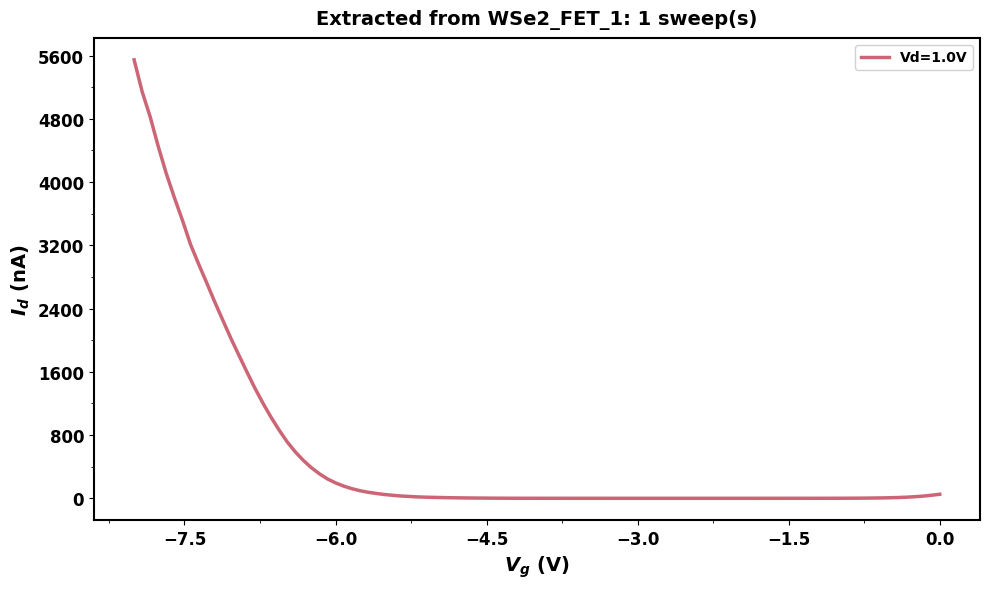

Save as filename (without .txt) [WSe2_FET_1_extracted]:  WSe2_FET_Vd1V_Vg-8to0
Output directory [.]:  



Saved: /Users/chandrasekarsivakumar/Library/CloudStorage/OneDrive-国立研究開発法人物質・材料研究機構/1 NIMS Work/2 Data/3 Electrical Masurements/1_Python_Scripts_for_plotting/Scripts_v12/WSe2_FET_Vd1V_Vg-8to0.txt
  Sweeps: 1, Points: 101
  Format: Keysight B2912A compatible
  Use with: python 1Plot_MergedAAT_FET_v5.py WSe2_FET_Vd1V_Vg-8to0.txt


>>  status



  Label           Raw      Cleaned    Retrace    Status
  ------------------------------------------------------------
  WSe2_FET_1      5        -          No         Raw


>>  export


Nothing to export. Use "merge" first.


In [ ]:
# ================================================================
# CELL 2: Run this to start the interactive tool
# ================================================================
merger.start()